# Homework 7: Machine Learning with Spark
**Harvard University**<br>
**Fall 2017**<br>
**Author: Tim Hagmann**


**Note:** This notebook is hosted on Amazon EC2 with Python *2.7* and Spark *2.2* and Jupyter Notebook. The easiest way to replicate it is using a docker image like *jupyter/all-spark-notebook*. To use it after intalling docker simply run the following command: 

```bash
docker run -it --rm -p 8888:8888 --name spark jupyter/all-spark-notebook 
```

# Problem 1 (25%)
**Question:** Attached file *auto_mpg_original.csv* contains a set of data on automobile characteristics and fuel consumption. File *auto_mpg_description.csv* contains the description of the data.  Import data into Spark. Randomly select *10-20%* of you data for testing and use remaining data for training. Find all *null values* in all *numerical* columns. Replace *nulls*, if any, with *average values* for respective columns using *Spark Data Frame API*.

### Setup spark
The first step of the analysis is to setup the spark context and load all the necessary libraries

In [1]:
# Load spark
import findspark
findspark.init("/home/tim/spark")

# Import libraries
import os
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
import pyspark.mllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [2]:
# Start spark context
conf = SparkConf().setAppName("hw7").setMaster("local[*]")
sc = SparkContext(conf=conf)

In [3]:
from pyspark.ml.feature import Imputer
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit
sqlContext = SQLContext(sc)

### Load data
Next we can load the data and split the csv file by *comma* delimited mode.

In [4]:
# Read data
auto = sc.textFile("/home/tim/e63-coursework/hw7/data/auto_mpg_original-1.csv",
                   use_unicode=False)

# Split data
autordd = auto.map(lambda line: line.split(","))

With that we can add the column names and split the dataset into numerical and categorical variables.

In [5]:
# Create dataframe
df = autordd.map(lambda line: Row(mpg = line[0], cylinders = line[1],
                                  displacement=line[2], horsepower=line[3],
                                  weight=line[4], acceleration=line[5],
                                  my=line[6], origin=line[7],
                                  name=line[8])).toDF()

# Define numeric variables
df_num = df.select(df.mpg.cast('float'), df.displacement.cast('float'),
                   df.horsepower.cast('float'), df.weight.cast('float'),
                   df.acceleration.cast('float'), df.cylinders.cast('float'),
                   df.my.cast('float'), df.origin.cast('float'))

# Define categorical variables
df_cat = df.select(df.name.cast('string'))

### Numerical variables
Next we can have a look at the summary statistic of the numerical variabels.

In [6]:
# Calculate summary
df_num_summary = df_num.describe()

# Show numeric variabels I
df_num_summary['summary', 'mpg', 'displacement', 'horsepower', 'weight'].show()

+-------+-----------------+------------------+------------------+------------------+
|summary|              mpg|      displacement|        horsepower|            weight|
+-------+-----------------+------------------+------------------+------------------+
|  count|              405|               406|               405|               406|
|   mean|23.49333333144953| 194.7795566502463|104.83703703703704|2979.4137931034484|
| stddev|7.778236919313246|104.92245837948875|38.655601865131466| 847.0043282393509|
|    min|              9.0|              68.0|              46.0|            1613.0|
|    max|             46.6|             455.0|             230.0|            5140.0|
+-------+-----------------+------------------+------------------+------------------+



In [7]:
# Show numeric variable II
df_num_summary['summary', 'acceleration', 'cylinders', 'my', 'origin'].show()

+-------+------------------+------------------+-----------------+------------------+
|summary|      acceleration|         cylinders|               my|            origin|
+-------+------------------+------------------+-----------------+------------------+
|  count|               406|               406|              406|               406|
|   mean|15.519704440544391| 5.475369458128079|75.92118226600985|1.5689655172413792|
| stddev| 2.803358855032557|1.7121596315485292|3.748737345455887|0.7974789993244706|
|    min|               8.0|               3.0|             70.0|               1.0|
|    max|              24.8|               8.0|             82.0|               3.0|
+-------+------------------+------------------+-----------------+------------------+



The above count statistics show, that there are NA's present. This appears to be the case for *mpg* and *horsepower*.

### Impute Values
With Spark 2.2. there is a new the impute function available. With the help of this function the null values can be replaced with the group mean. 

In [8]:
# Impute NA's with the average (new function on Spark 2.2)
imputer = Imputer(inputCols=df_num.columns, outputCols=["{}".format(c)
                                                        for c in df_num.columns])
df_num = imputer.setStrategy("mean").fit(df_num).transform(df_num)

### Join numeric and categorical together
Having imputed the numerical variables, the next step is to join the dataframe back into one.

In [9]:
# Add ID variable
df_num = df_num.withColumn("row_id", monotonically_increasing_id())
df_cat = df_cat.withColumn("row_id", monotonically_increasing_id())

# Join dataframe
df2 = df_num.join(df_cat, "row_id").drop("row_id")

# Show data
df2.show(5)

+----+------------+----------+------+------------+---------+----+------+-------+
| mpg|displacement|horsepower|weight|acceleration|cylinders|  my|origin|   name|
+----+------------+----------+------+------------+---------+----+------+-------+
|25.0|       110.0|      87.0|2672.0|        17.5|      4.0|70.0|   2.0|peugeot|
|26.0|       121.0|     113.0|2234.0|        12.5|      4.0|70.0|   2.0|    bmw|
|27.2|       119.0|      97.0|2300.0|        14.7|      4.0|78.0|   3.0| datsun|
|25.0|        97.5|      80.0|2126.0|        17.0|      4.0|72.0|   1.0|  dodge|
|25.0|       140.0|      92.0|2572.0|        14.9|      4.0|76.0|   1.0|  capri|
+----+------------+----------+------+------------+---------+----+------+-------+
only showing top 5 rows



**Note:** In order to use the categorical variable *name* we use *1-of-k binary encoding*. This is not necessary for the analysis in problem 2. 

### Select variables
For the following analysis in problem 2, only variables *mpg* and *horsepower* are used. That is we only select those values.

In [10]:
# Select variables
df3 = df2.select(df2.mpg.cast('float'), df2.horsepower.cast('float'))

# Show data
df3.show(5)

+----+----------+
| mpg|horsepower|
+----+----------+
|25.0|      87.0|
|26.0|     113.0|
|27.2|      97.0|
|25.0|      80.0|
|25.0|      92.0|
+----+----------+
only showing top 5 rows



### Labeled points (could also be done in problem 2)
In order to programmatically tell the ML Algorithm the features and target variables we're adding labeled points to the data. 

In [11]:
# Create labeled points
df_labeled = df3.rdd.map(lambda r : LabeledPoint(r[0], r[1:]))
df_labeled.take(5)

[LabeledPoint(25.0, [87.0]),
 LabeledPoint(26.0, [113.0]),
 LabeledPoint(27.2000007629, [97.0]),
 LabeledPoint(25.0, [80.0]),
 LabeledPoint(25.0, [92.0])]

### Creat test and train dataframes
In order to control for overfitting we're creating datasets for training (80%) and testing (20%) the models.

In [12]:
# Test and learning set.
df_train, df_test = df_labeled.randomSplit([.8, .2], seed=123)

# Cache data
df_train = df_train.cache()
df_test = df_test.cache()

### Summary of the data

In [13]:
# Get values
print "Training data size: %d" % df_train.count()
print "Test data size: %d" % df_test.count()
print "Total data size: %d " % df3.count()
print "Train + Test size : %d" % (df_train.count() + df_test.count())

Training data size: 315
Test data size: 91
Total data size: 406 
Train + Test size : 406


There are 315 observation in the training set and 91 in the testset. This is equal to the number of observations in the overall dataset.

# Problem 2 (25%)
**Question:** Look initially at two variables in the data set from the previous problem: the *horsepower* and the *mpg* (miles per gallon). Treat *mpg* as a feature and *horsepower* as the target variable (label). Use *MLlib* linear regression to identify the model for the relationship. Use the *test data* to illustrate *accuracy* of the *linear regression model* and its ability to predict the relationship. Calculate *two standard measures* of model *accuracy*. Create a *diagram* using any technique of convenience to presents the model (straight line), and the original test data. Please label your axes and use different colors for original data and predicted data.


### Accuracy functions
We're first defining the accuracy function. We're measaring the *mean squared error*, *mean absolut error* and the *root mean squared log error*.  

In [14]:
# MSE
def squared_error(actual, pred):
    return (pred - actual)**2

# MAE
def abs_error(actual, pred):
    return np.abs(pred - actual)

# RMSLE
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

### Regression model
Next we're calculating a linear regression model.

In [ ]:
# Calculate model
fit_lin = LinearRegressionWithSGD.train(df_train, 1000, .0001, intercept=False)
print("Linear Model Info:" + str (fit_lin))

### Prediction
Having the above model we're next calculating the estimated values on the test set. Based on that we can calculate the accuracy rate.

In [16]:
# Calculate true vs. prediction
tbl_pred = df_test.map(lambda x: (x.label, fit_lin.predict(x.features)))

# Calculate two accuracy measures
mse = tbl_pred.map(lambda (t, p): squared_error(t, p)).mean()
mae = tbl_pred.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(tbl_pred.map(lambda(t,p):squared_log_error(t,p)).mean())

# Print output
print ("Linear model: Mean squared error: %2.4f" % mse)
print ("Linear model: Mean absolute error: %2.4f" % mae)
print ("Linear model: Root mean squared log error: %2.4f" % rmsle)

Linear model: Mean squared error: 242.6391
Linear model: Mean absolute error: 12.3945
Linear model: Root mean squared log error: 0.6914


It appears that we're producing a bit of error. However, we have to be careful with the interpretation as we didn't standartize the model. Furthermore, in order to make the accuracy measures comparable we would have to calculate a baseline model. Without all this there is however another method assessing the goodness of fit and that is to visualize the model in a scatterplot.

### Visualization
Having calculated the accuracy rate a good indicator for the goodness of fit is to visualize the data. 

In [17]:
pd_train_pred = df_train.map(lambda p: (float(p.label), float(fit_lin.predict(p.features)),
                                        float(p.features[0]))).toDF().toPandas()
pd_test_pred = df_test.map(lambda p: (float(p.label), float(fit_lin.predict(p.features)),
                                      float(p.features[0]))).toDF().toPandas()
pd_train_pred.columns = ['mpg', 'mpg_pred', 'horsepower']
pd_test_pred.columns = ['mpg', 'mpg_pred', 'horsepower']

### Plot I: Actual vs. prediction (test data)
In order to see the goodness of fit we're visualizing the model on top of a scatterplot.

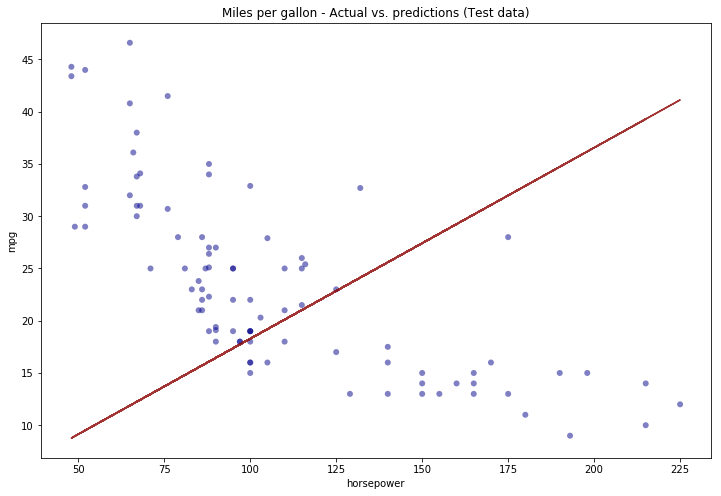

In [18]:
plt.figure(1, figsize=(12,8))
plt.scatter(pd_test_pred['horsepower'], pd_test_pred['mpg'],
            c='darkblue', alpha=0.5, edgecolor="")
plt.plot(pd_test_pred['horsepower'], pd_test_pred['mpg_pred'],
         c='darkred', alpha=0.8)
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('Miles per gallon - Actual vs. predictions (Test data)')
plt.show()

As can be seen above, the model is quit a bad fit for the data. This is because the data appears no be of a polynomic nature. If we'd like to stick to the regression method, a good next step would be to fit fit a model with a quadratic term and an intercept. However, an alternative would be to fit a non-linear model such as a regression tree. This is what we're going to do in problem 4.  

### Plot I: Actual vs. prediction (all data) [optional]
Because we only took 20% of the data as test. I also visualized the overall data to the model. However, the conclusion is the same as above.

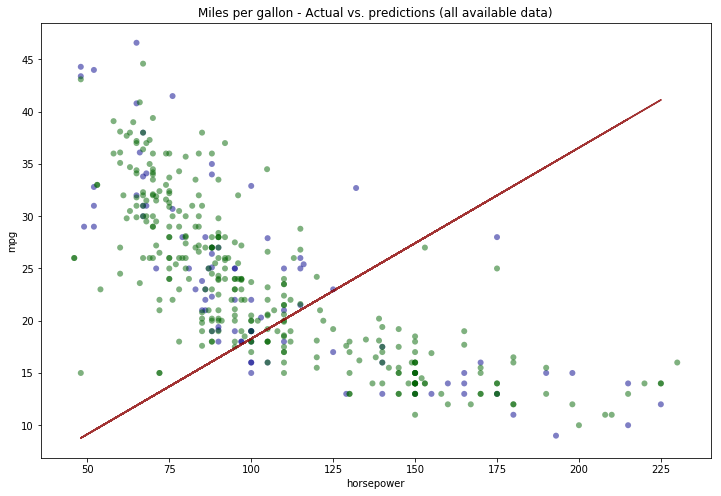

In [19]:
plt.figure(1, figsize=(12,8))
plt.scatter(pd_test_pred['horsepower'], pd_test_pred['mpg'],
            c='darkblue', alpha=0.5, edgecolor="")
plt.scatter(pd_train_pred['horsepower'], pd_train_pred['mpg'],
            c='darkgreen', alpha=0.5, edgecolor="")
plt.plot(pd_test_pred['horsepower'], pd_test_pred['mpg_pred'],
         c='darkred', alpha=0.8)
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.title('Miles per gallon - Actual vs. predictions (all available data)')
plt.show()

# Problem 3 (25%)
**Question:** Consider attached file *Bike-Sharing-Dataset.zip*. This is the bike set discussed in class. Do *not* use all columns of the data set. Retain the following variables: *season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, cnt*. Discard others. Regard *cnt* as the target variable and all other variables as features.  Please note that some of those are categorical variables. Identify categorical variables and use *1-of-k* *binary encoding* for those variables. If there are any null values in numerical columns, replace those with average values for those columns using *Spark DataFrame API*. Train your model using *LinearRegressionSGD* method. Use test data (15% of all) to assess the quality of prediction for *cnt* variable. Calculate at least two performance metrics of your model.

### Functions
The following functions are used in this problem set.

In [20]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct()
                                  .zipWithIndex().collectAsMap()

def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[0:8] :
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[8:12]])
    return np.concatenate((cat_vec, num_vec))

def extract_label(record):
    return float(record[-1])

### Creat spark context

In [21]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("p3_df_count")
                            .getOrCreate()

### Load data
We're first loading the from the csv file as well as droping some unwanted variables.  

In [22]:
# Load data
df_bike = spark.read.csv("file:///home/tim/e63-coursework/hw7/data/hour.csv",
                         nullValue='NA', header=True)

In [23]:
# Select data and arrange (categories first) 
df_bike = df_bike.select(df_bike.season.cast('float'), df_bike.yr.cast('float'),
                         df_bike.mnth.cast('float'), df_bike.hr.cast('float'),
                         df_bike.holiday.cast('float'), df_bike.weekday.cast('float'),
                         df_bike.workingday.cast('float'), df_bike.weathersit.cast('float'),
                         df_bike.temp.cast('float'), df_bike.atemp.cast('float'),
                         df_bike.hum.cast('float'), df_bike.windspeed.cast('float'),
                         df_bike.cnt.cast('float'))

### Impute missings
Next we're imputing missing values with the average value

In [24]:
# Impute NA's with the average (new function on Spark 2.2)
imputer = Imputer(inputCols=df_bike.columns, outputCols=["{}".format(c)
                                                         for c in df_bike.columns])
x = imputer.setStrategy("mean").fit(df_bike).transform(df_bike)

### Look at the data
Next we can have a first look at the data

In [25]:
df_bike.show(5)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed| cnt|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+
|   1.0|0.0| 1.0|0.0|    0.0|    6.0|       0.0|       1.0|0.24|0.2879|0.81|      0.0|16.0|
|   1.0|0.0| 1.0|1.0|    0.0|    6.0|       0.0|       1.0|0.22|0.2727| 0.8|      0.0|40.0|
|   1.0|0.0| 1.0|2.0|    0.0|    6.0|       0.0|       1.0|0.22|0.2727| 0.8|      0.0|32.0|
|   1.0|0.0| 1.0|3.0|    0.0|    6.0|       0.0|       1.0|0.24|0.2879|0.75|      0.0|13.0|
|   1.0|0.0| 1.0|4.0|    0.0|    6.0|       0.0|       1.0|0.24|0.2879|0.75|      0.0| 1.0|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+
only showing top 5 rows



### Seting type
Next we're setting the type of the variables

In [26]:
# Select data and arrange (categories first) 
df_bike = df_bike.select(df_bike.season.cast('int'), df_bike.yr.cast('int'),
                         df_bike.mnth.cast('int'), df_bike.hr.cast('int'),
                         df_bike.holiday.cast('int'), df_bike.weekday.cast('int'),
                         df_bike.workingday.cast('int'), df_bike.weathersit.cast('int'),
                         df_bike.temp.cast('float'), df_bike.atemp.cast('float'),
                         df_bike.hum.cast('float'), df_bike.windspeed.cast('float'),
                         df_bike.cnt.cast('float'))
df_bike.show(5)

+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+
|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed| cnt|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+
|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|16.0|
|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|40.0|
|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|32.0|
|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|13.0|
|     1|  0|   1|  4|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0| 1.0|
+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+----+
only showing top 5 rows



We are left with 12 variables (features). The first eight are categorical, while the last 4
are numeric variables. The target variable is *cnt*

### Get mapping
Next we're getting the mapping of the values 

In [27]:
rdd_bike = df_bike.rdd
mappings = [get_mapping(rdd_bike, i) for i in range(0,8)]
print (mappings)

[{1: 0, 2: 1, 3: 2, 4: 3}, {0: 0, 1: 1}, {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11}, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23}, {0: 0, 1: 1}, {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}, {0: 0, 1: 1}, {1: 0, 2: 1, 3: 2, 4: 3}]


### Summary data

In [28]:
cat_len = np.sum(map(len, mappings))
print(rdd_bike.first()[8:12])
num_len = len(rdd_bike.first()[8:12])
total_len = num_len + cat_len

(0.23999999463558197, 0.28790000081062317, 0.8100000023841858, 0.0)


In [29]:
print "Feature vector length for categorical features: %d" % cat_len
print "Feature vector length for numerical features: %d" % num_len
print "Total feature vector length: %d" % total_len

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


There are 57 categorical features (dummys) and 4 numerical features in the data.

### Define labeled points
Next we're defining the labeled points

In [30]:
rdd_bike.take(5)

[Row(season=1, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.23999999463558197, atemp=0.28790000081062317, hum=0.8100000023841858, windspeed=0.0, cnt=16.0),
 Row(season=1, yr=0, mnth=1, hr=1, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.2199999988079071, atemp=0.2727000117301941, hum=0.800000011920929, windspeed=0.0, cnt=40.0),
 Row(season=1, yr=0, mnth=1, hr=2, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.2199999988079071, atemp=0.2727000117301941, hum=0.800000011920929, windspeed=0.0, cnt=32.0),
 Row(season=1, yr=0, mnth=1, hr=3, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.23999999463558197, atemp=0.28790000081062317, hum=0.75, windspeed=0.0, cnt=13.0),
 Row(season=1, yr=0, mnth=1, hr=4, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.23999999463558197, atemp=0.28790000081062317, hum=0.75, windspeed=0.0, cnt=1.0)]

In [31]:
rdd_bike2 = rdd_bike.map(lambda r: LabeledPoint(extract_label(r),
                                                extract_features(r)))
first_point = rdd_bike2.first()
print ("Label: " + str(first_point.label))
print ("Linear Model feature vector:\n" + str(first_point.features))
print ("Linear Model feature vector length: " + str(len(first_point.features)))

Label: 16.0
Linear Model feature vector:
[1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.239999994636,0.287900000811,0.810000002384,0.0]
Linear Model feature vector length: 61


### Creat test and train
We're spliting the data into 85% training and 15% testing data

In [32]:
df_train, df_test = rdd_bike2.randomSplit([.85, .15], seed=123)
df_train = df_train.cache()
df_test = df_test.cache()

### Linear regression
Next we're calculating the regression model with all the features against the training data.

In [33]:
fit_lin = LinearRegressionWithSGD.train(df_train, 500, .0001)
print(fit_lin)

(weights=[0.116168979055,0.226422311253,0.26017070975,0.207218347234,0.304143328575,0.505837018717,0.0327945991684,0.0371773618931,0.0565337706308,0.0667011789332,0.0826814154315,0.08409107946,0.0845591998996,0.0860952081048,0.0857801993262,0.0788704146215,0.0627833600318,0.0519125597911,0.00969022399079,0.00582491092694,0.00384725572485,0.0018203010546,0.000830987831168,0.00321118575128,0.013049629389,0.0377621318743,0.0640003475319,0.0403187705981,0.0308375689067,0.0370608113163,0.0439918363766,0.0464577971115,0.0443805281468,0.0446948528925,0.0558068757195,0.0848836817634,0.0780685691973,0.0535618729009,0.0403094627869,0.0303207829371,0.0237388557259,0.0155111068376,0.791105781616,0.0188745656761,0.110501437704,0.111924945903,0.114882532903,0.117153119476,0.11907608301,0.118079632458,0.118362595839,0.247738599219,0.562241748073,0.575140943642,0.195657963559,0.0391272241901,5.42159009355e-05,0.463262393904,0.439289547053,0.45879690772,0.163250877965], intercept=0.0)


### Prediction
With the above model we can predict the values from the test dataset.

In [34]:
df_pred = df_test.map(lambda p: (p.label, fit_lin.predict(p.features)))
print ("Linear Model predictions: " + str(df_pred.take(10)))

Linear Model predictions: [(36.0, 2.9554706504526154), (110.0, 2.649529971102679), (53.0, 2.556992508024055), (53.0, 2.4540270975512151), (61.0, 2.9512112721402763), (72.0, 2.9442030091125835), (76.0, 2.9553150319396515), (52.0, 3.0093229888232536), (112.0, 3.0116659774994385), (2.0, 3.0173947703379684)]


### Accuracy
Next we can calculate the accuracy of our model.

In [35]:
mse2 = df_pred.map(lambda (t, p): squared_error(t, p)).mean()
mae2 = df_pred.map(lambda (t, p): abs_error(t, p)).mean()
rmsle2=np.sqrt(df_pred.map(lambda(t,p):squared_log_error(t,p)).mean())
print ("Linear model: - Mean squared error: %2.4f" % mse)
print ("Linear model: - Mean absolute error: %2.4f" % mae)
print ("Linear model: - Root mean squared log error: %2.4f" % rmsle)

Linear model: - Mean squared error: 242.6391
Linear model: - Mean absolute error: 12.3945
Linear model: - Root mean squared log error: 0.6914


The model has a MSE of 242.64 and a MAE of 12.39 while the RMSLE is at 0.69.

# Problem 4 (25%)
**Question:** Use a *Decision Tree model* to predict *mpg* values in *auto_mpg_original.txt* data. Assess accuracy of your prediction using at least two performance metrics.

### Functions
The below problem needs the following functions to be solved.

In [36]:
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[0:4] :
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[4:8]])
    return np.concatenate((cat_vec, num_vec))

def extract_features_dt(record):
    return np.array(map(float, record[0:8]))

### Prepare data
First we're preparing the dataframe. We're using the same dataframe as used in problem 1 & 2. That means we can pick up from dataframe2 (df2). The advantage of the regression tree is that we can simply hash the car name for our analyis. 

In [37]:
# Prepare data
df_car = df2.select(df2.cylinders.cast('int'), df2.my.cast('int'),
                    abs(hash(df2.name)).alias('name').cast('int'),
                    df2.origin.cast('int'), df2.acceleration, df2.displacement,
                    df2.horsepower, df2.weight, df2.mpg)
rdd_car = df_car.rdd

### Create mapping
Next we can create the mapping.

In [38]:
# Create Mapping
mappings = [get_mapping(rdd_car, i) for i in range(0,4)]
print (mappings)

[{8: 4, 3: 0, 4: 1, 5: 2, 6: 3}, {70: 0, 71: 1, 72: 2, 73: 3, 74: 4, 75: 5, 76: 6, 77: 7, 78: 8, 79: 9, 80: 10, 81: 11, 82: 12}, {1144649218: 2, 1936435720: 24, 1355140489: 18, 1843726348: 32, 497091343: 29, 2046502744: 30, 1904964373: 35, 537497878: 16, 880171162: 34, 1304410654: 11, 1884908912: 23, 1905148707: 20, 538059249: 8, 85824937: 27, 1121791217: 0, 537608040: 4, 712958643: 5, 695351817: 1, 1890915261: 13, 2091404737: 28, 420531909: 21, 1615138977: 37, 656445650: 10, 1335658835: 3, 1040546260: 12, 1642082133: 26, 160577496: 19, 1221650650: 9, 1488979555: 33, 1376505445: 6, 358268264: 14, 1553142249: 7, 1408468775: 36, 1064022512: 22, 94873064: 15, 1656265720: 25, 707754747: 31, 324706684: 17}, {1: 0, 2: 1, 3: 2}]


### Feature description
Next we can output the features used for the prediction. 

In [39]:
print "Length of categorical features: %d" % np.sum(map(len, mappings))
print "Length of numerical features: %d" % len(rdd_car.first()[4:9])
print "Total feature vector length: %d" % (np.sum(map(len, mappings)) + len(rdd_car.first()[4:9]))

Length of categorical features: 59
Length of numerical features: 5
Total feature vector length: 64


### Label points
Next we can label the dataset.

In [40]:
df_car2 = rdd_car.map(lambda r: LabeledPoint(extract_label(r),
                                             extract_features_dt(r)))

In [41]:
df_car2.take(5)

[LabeledPoint(25.0, [4.0,70.0,1304410654.0,2.0,17.5,110.0,87.0,2672.0]),
 LabeledPoint(26.0, [4.0,70.0,1064022512.0,2.0,12.5,121.0,113.0,2234.0]),
 LabeledPoint(27.2000007629, [4.0,78.0,1936435720.0,3.0,14.6999998093,119.0,97.0,2300.0]),
 LabeledPoint(25.0, [4.0,72.0,420531909.0,1.0,17.0,97.5,80.0,2126.0]),
 LabeledPoint(25.0, [4.0,76.0,1355140489.0,1.0,14.8999996185,140.0,92.0,2572.0])]

In [42]:
first_point = df_car2.first()
print ("Label: " + str(first_point.label))
print ("Linear Model feature vector:\n" + str(first_point.features))
print ("Linear Model feature vector length: " + str(len(first_point.features)))

Label: 25.0
Linear Model feature vector:
[4.0,70.0,1304410654.0,2.0,17.5,110.0,87.0,2672.0]
Linear Model feature vector length: 8


### Split data
In order to control for overfitting we're splitting the dataset. We're using the same split as in problem 1, i.e., 80% training and 20% test set.

In [43]:
# Split data
df_train, df_test = df_car2.randomSplit([.8, .2], seed=123)

df_train = df_train.cache()
df_test = df_test.cache()

### Regression tree
Next we can build the regression tree with the *DecisionTree* method. It thas a default tree depth of 5. As we're using the labelpoint we don't have to input any categorical features. 

In [44]:
fit_tree = DecisionTree.trainRegressor(df_train,{})

### Prediction
With the above model we can predict the values in the test set.

In [45]:
preds = fit_tree.predict(df_test.map(lambda p: p.features))
actual = df_test.map(lambda p: p.label)
tbl_pred = actual.zip(preds)

### Tree caracteristics
Next we can output the tree characteristics.

In [46]:
print ("Decision tree predictions: " + str(tbl_pred.take(5)))
print ("Decision tree depth: " + str(fit_tree.depth()))
print ("Decision tree number of nodes: " + str(fit_tree.numNodes()))

testErr = tbl_pred.filter(lambda (v, p): v != p).count() / float(df_test.count())
print('Test error = ' + str(testErr))

Decision tree predictions: [(44.0, 39.099998474121094), (19.0, 18.40909090909091), (18.0, 20.390909108248625), (22.0, 20.390909108248625), (14.0, 12.636363636363637)]
Decision tree depth: 5
Decision tree number of nodes: 63
Test error = 1.0


The tree has 63 nodes and tree depth of 5. 

### Accuracy 
Next we can have a look at the accuracy of the model.

In [47]:
mse = tbl_pred.map(lambda (t, p): squared_error(t, p)).mean()
mae = tbl_pred.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(tbl_pred.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision tree: Mean squared error: %2.4f" % mse
print "Decision tree: Mean absolute error: %2.4f" % mae
print "Decision tree: Root mean squared log error: %2.4f" % rmsle

Decision tree: Mean squared error: 24.0046
Decision tree: Mean absolute error: 3.3218
Decision tree: Root mean squared log error: 0.2085


The above tree achieves a MSE of 24, a MAE of 3.3 and a RMSLE of 0.2. comparing that with the simple linear regression model from problem 2 (MSE: 242.64, MAE: 12.39 and RMSLE: 0.69) the regression tree clearly outperforms the regression model. This was to be expected as we're using much more features. Furthremore, as already mentioned in problem 2, some of the data shows a non-linear relationship with the target variable.

### Output tree (optional)
Last but not least we can have a look at the actual tree.

In [ ]:
print(fit_tree.toDebugString())

DecisionTreeModel regressor of depth 5 with 63 nodes
  If (feature 0 <= 5.0)
   If (feature 7 <= 2219.0)
    If (feature 1 <= 77.0)
     If (feature 4 <= 19.5)
      If (feature 7 <= 2075.0)
       Predict: 31.023809523809526
      Else (feature 7 > 2075.0)
       Predict: 27.366666666666667
     Else (feature 4 > 19.5)
      If (feature 1 <= 71.0)
       Predict: 22.333333333333332
      Else (feature 1 > 71.0)
       Predict: 25.25
    Else (feature 1 > 77.0)
     If (feature 6 <= 58.0)
      If (feature 1 <= 78.0)
       Predict: 43.099998474121094
      Else (feature 1 > 78.0)
       Predict: 39.099998474121094
     Else (feature 6 > 58.0)
      If (feature 5 <= 91.0)
       Predict: 36.236841804102845
      Else (feature 5 > 91.0)
       Predict: 34.14117656034582
   Else (feature 7 > 2219.0)
    If (feature 1 <= 78.0)
     If (feature 7 <= 2300.0)
      If (feature 4 <= 18.200000762939453)
       Predict: 26.35384618318998
      Else (feature 4 > 18.200000762939453)
       Predic

As can be seen above, the tree uses a multitude of features that the tree selected as spliting points.